In [ ]:
!pip install opencv-python
import cv2
import os
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
!pip install bayesian-optimization
!pip install bayesian-optimization
!pip install lightgbm

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device = torch.device('cpu')

sns.set(color_codes=True)

In [ ]:
class FeatureDataset(Dataset):
    '''
    Args: 
    - x is a 2D numpy array [x_size, x_features] (e.g. compositions)
    - y is the target (e.g. property to predict)
    - descriptors are additional features for correlation calculation (e.g. physical properties)
    '''
    def __init__(self, x, y, descriptors=None):
        self.x = x
        self.y = y
        self.descriptors = descriptors if descriptors is not None else x  

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        if self.descriptors is not None:
            return torch.FloatTensor(self.x[idx]), torch.FloatTensor(self.y[idx]), torch.FloatTensor(self.descriptors[idx])
        return torch.FloatTensor(self.x[idx]), torch.FloatTensor(self.y[idx])


In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
class FWAE(nn.Module):
    def __init__(self, input_size):
        super(FWAE, self).__init__()
        self.input_size = input_size  

        # encoder
        self.encoder = nn.Sequential(
                        nn.Linear(self.input_size,256),
                        nn.LayerNorm(256),
                        nn.ReLU(),
                        nn.Linear(256, 128),
                        nn.LayerNorm(128),
                        nn.ReLU(),
                        nn.Linear (128, 64),
                        nn.LayerNorm(64),
                        nn.ReLU(),
                        nn.Linear(64, 2),
                        )

        # decoder
        self.decoder = nn.Sequential(
                        nn.Linear(2, 64),
                        nn.LayerNorm(64),
                        nn.ReLU(),
                        nn.Linear(64, 128),
                        nn.LayerNorm(128),
                        nn.ReLU(),
                        nn.Linear(128,256),
                        nn.LayerNorm(256),
                        nn.ReLU(),
                        nn.Linear(256, self.input_size),
                        nn.Softmax(dim=1), 
                        )
        self.apply(weights_init)

    def forward(self, x):
        z = self._encode(x)
        x_recon = self._decode(z)
        return x_recon, z
    
    def _encode(self, x):
        return self.encoder(x)

    def _decode(self, z):
        return self.decoder(z)

In [ ]:
def same_seeds(seed): 
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def get_latents(model, dataset): 
    model.to(device).eval() 
    latents = []
    with torch.no_grad(): 
        dataloader = DataLoader(dataset, batch_size=128, shuffle=False)
        for i, data in enumerate(dataloader):
            x = data[0].to(device)
            recon_x, z = model(x)
            
            latents.append(z.detach().cpu().numpy())
    return np.concatenate(latents,axis=0)

def imq_kernel(X: torch.Tensor, Y: torch.Tensor, h_dim: int): 
    batch_size = X.size(0)

    norms_x = X.pow(2).sum(1, keepdim=True)  
    prods_x = torch.mm(X, X.t()).to(device)  
    dists_x = norms_x + norms_x.t() - 2 * prods_x 

    norms_y = Y.pow(2).sum(1, keepdim=True).to(device)  
    prods_y = torch.mm(Y, Y.t()).to(device) 
    dists_y = norms_y + norms_y.t() - 2 * prods_y

    dot_prd = torch.mm(X, Y.t())
    dists_c = norms_x + norms_y.t() - 2 * dot_prd

    stats = 0
    for scale in [.1, .2, .5, 1., 2., 5., 10.]: 
        C = 2 * h_dim * 1.0 * scale
        res1 = C / (C + dists_x)
        res1 += C / (C + dists_y)

        if torch.cuda.is_available():
            res1 = (1 - torch.eye(batch_size).to(device)) * res1
        else:
            res1 = (1 - torch.eye(batch_size)) * res1

        res1 = res1.sum() / (batch_size - 1)
        res2 = C / (C + dists_c)
        res2 = res2.sum() * 2. / (batch_size)
        stats += res1 - res2

    return stats


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from torch.optim.lr_scheduler import StepLR
same_seeds(1) 
params = {
    'num_epoch' : 500,
    'batch_size' : 80,
    'lr' : 8e-4,
    'weight_decay' : 0,
    'sigma' : 3,
    'MMD_lambda' : 1e-4,
    'model_name' : 'FWAE',
} 
all = pd.read_excel('data-1.xlsx', header=0).iloc[:,0:12].to_numpy()
print(all.shape)
raw_x = all[:,0:7]
raw_descriptors = all[:,7:11]
raw_y = all[:,11].reshape(-1,1)

scaler = MinMaxScaler()
raw_descriptors = scaler.fit_transform(raw_descriptors)


dataset = FeatureDataset(raw_x[:], raw_y[:], raw_descriptors[:]) 
dataloader = DataLoader(dataset, batch_size=params['batch_size'], shuffle=True) 
print(raw_x[0:10],raw_y[0:10],raw_descriptors[0:5])
print(raw_x.shape[1])

(154, 12)
[[0.5     0.      0.      0.5     0.      0.      0.     ]
 [0.5     0.      0.      0.495   0.005   0.      0.     ]
 [0.5     0.      0.      0.495   0.      0.005   0.     ]
 [0.5     0.      0.      0.4925  0.0075  0.      0.     ]
 [0.5     0.      0.      0.49    0.      0.      0.01   ]
 [0.5     0.      0.      0.489   0.011   0.      0.     ]
 [0.5     0.      0.      0.48875 0.01125 0.      0.     ]
 [0.5     0.      0.      0.485   0.      0.015   0.     ]
 [0.5     0.      0.      0.485   0.      0.      0.015  ]
 [0.5     0.      0.      0.48    0.      0.02    0.     ]] [[190.]
 [273.]
 [250.]
 [317.]
 [361.]
 [343.]
 [334.]
 [400.]
 [272.]
 [409.]] [[1.         0.88568927 0.78653066 0.        ]
 [0.97871831 0.89203986 0.76594568 0.01659623]
 [0.96542363 0.8687962  0.7252673  0.02711735]
 [0.9682201  0.89521516 0.75565319 0.02489435]
 [0.87730295 0.88588613 0.78358117 0.1       ]]
7


In [ ]:
from bayes_opt import BayesianOptimization
from torch.optim import AdamW
import torch.nn.functional as F
import pandas as pd
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def optimize_FWAE(lr, batch_size, MMD_lambda, sigma, weight_decay):
        params = {
        'num_epoch': 500,
        'batch_size': int(batch_size),  
        'lr': lr,
        'weight_decay': weight_decay,  
        'sigma': sigma,
        'MMD_lambda': MMD_lambda,
        'model_name': 'FWAE',
    }

    
    model = FWAE(raw_x.shape[1]).to(device)
    optimizer = AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    
    loss_ = train_FWAE(model, optimizer, dataloader, params)

    
    return -min(loss_)  


pbounds = {
    'lr': (1e-6, 1e-3),           
    'batch_size': (10, 70),      
    'MMD_lambda': (1e-4, 1e-2),   
    'sigma': (0.1, 5),            
    'weight_decay': (1e-6, 1e-3)  
}


optimizer_bo = BayesianOptimization(
    f=optimize_FWAE,  
    pbounds=pbounds,  
    random_state=1   
)


output_folder = os.path.join(os.getcwd(), 'reconstructeddata')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)


param_results = []


def train_FWAE(model, optimizer, dataloader, params):
    num_epoch = params['num_epoch']
    sigma = params['sigma']  
    MMD_lambda = params['MMD_lambda']  

    loss_ = []  
    for epoch in range(num_epoch):
        total_loss = []  
        for i, data in enumerate(dataloader):
            x = data[0].to(device)  
            y = data[1].to(device)  

            model.train()  
            recon_x, z_tilde = model(x)  

            
            z = sigma * torch.randn(z_tilde.size()).to(device)

            
            recon_loss = F.binary_cross_entropy(recon_x, x, reduction='mean')

            
            MMD_loss = imq_kernel(z_tilde, z, h_dim=2).to(device)
            MMD_loss = MMD_loss / x.size(0)  
            loss = recon_loss + MMD_loss * MMD_lambda  

            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            
            total_loss.append(loss.item())

        avg_loss = sum(total_loss) / len(total_loss)
        loss_.append(avg_loss)

    return loss_


optimizer_bo.maximize(init_points=10, n_iter=30)


for res in optimizer_bo.res:
    param_results.append({
        'lr': res['params']['lr'],
        'batch_size': res['params']['batch_size'],
        'MMD_lambda': res['params']['MMD_lambda'],
        'sigma': res['params']['sigma'],
        'weight_decay': res['params']['weight_decay'],  
        'loss': -res['target']  
    })


param_df = pd.DataFrame(param_results)
output_file = os.path.join(output_folder, 'Reconstrction_parameters.xlsx')
param_df.to_excel(output_file, index=False)

print(f'超参数组合和损失已保存到 {output_file}')

|   iter    |  target   | MMD_la... | batch_... |    lr     |   sigma   | weight... |
-------------------------------------------------------------------------------------
| 1         | -0.3449   | 0.004229  | 53.22     | 1.114e-06 | 1.581     | 0.0001476 |
| 2         | -0.2414   | 0.001014  | 21.18     | 0.0003462 | 2.044     | 0.0005393 |
| 3         | -0.2421   | 0.00425   | 51.11     | 0.0002052 | 4.403     | 2.836e-05 |
| 4         | -0.2415   | 0.006738  | 35.04     | 0.0005591 | 0.7879    | 0.0001989 |
| 5         | -0.2418   | 0.008027  | 68.1      | 0.0003141 | 3.492     | 0.0008765 |
| 6         | -0.2424   | 0.008957  | 15.1      | 4.002e-05 | 0.9322    | 0.0008783 |
| 7         | -0.2414   | 0.001074  | 35.27     | 0.0009579 | 2.713     | 0.0006922 |
| 8         | -0.2416   | 0.003224  | 51.19     | 0.0008348 | 0.1896    | 0.0007504 |
| 9         | -0.2418   | 0.00989   | 54.89     | 0.0002812 | 3.967     | 0.0001041 |
| 10        | -0.2415   | 0.004534  | 64.52     | 0.00

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from torch.optim.lr_scheduler import StepLR
same_seeds(1) 
params = {
    'num_epoch' : 500,
    'batch_size' : 60,
    'lr' : 0.0007521,
    'weight_decay' : 0.0005393,
    'sigma' : 1.25,
    'MMD_lambda' : 0.0008325,
    'model_name' : 'FWAE',
} 

all = pd.read_excel('data-1.xlsx', header=0).iloc[:,0:12].to_numpy()
print(all.shape)
raw_x = all[:,0:7]
raw_descriptors = all[:,7:11]
raw_y = all[:,11].reshape(-1,1)

scaler = MinMaxScaler()
raw_descriptors = scaler.fit_transform(raw_descriptors)




dataset = FeatureDataset(raw_x[:], raw_y[:], raw_descriptors[:])
dataloader = DataLoader(dataset, batch_size=params['batch_size'], shuffle=True) 
print(raw_x[20:40],raw_y[20:40],raw_descriptors[0:5])
print(raw_x.shape[1])

(154, 12)
[[0.5     0.      0.      0.45    0.05    0.      0.     ]
 [0.5     0.      0.      0.44    0.06    0.      0.     ]
 [0.5     0.      0.      0.42    0.      0.      0.08   ]
 [0.5     0.      0.      0.49125 0.00875 0.      0.     ]
 [0.5     0.      0.      0.41    0.09    0.      0.     ]
 [0.5     0.      0.      0.4     0.      0.      0.1    ]
 [0.495   0.005   0.      0.48    0.      0.02    0.     ]
 [0.495   0.005   0.      0.475   0.      0.025   0.     ]
 [0.495   0.005   0.      0.46    0.      0.04    0.     ]
 [0.492   0.008   0.      0.488   0.      0.012   0.     ]
 [0.49    0.01    0.      0.475   0.      0.025   0.     ]
 [0.49    0.01    0.      0.46    0.      0.04    0.     ]
 [0.485   0.015   0.      0.48    0.      0.02    0.     ]
 [0.485   0.015   0.      0.475   0.      0.025   0.     ]
 [0.485   0.015   0.      0.47    0.      0.03    0.     ]
 [0.485   0.015   0.      0.46    0.      0.04    0.     ]
 [0.485   0.015   0.      0.45    0.05    0.  

[001/500] loss: 0.3740820 Recon_loss: 0.3721267, MMD_loss: 2.3487298
[002/500] loss: 0.2774831 Recon_loss: 0.2753710, MMD_loss: 2.5370378
[003/500] loss: 0.2569736 Recon_loss: 0.2549691, MMD_loss: 2.4078686
[004/500] loss: 0.2550038 Recon_loss: 0.2529555, MMD_loss: 2.4604316
[005/500] loss: 0.2545878 Recon_loss: 0.2526487, MMD_loss: 2.3292863
[006/500] loss: 0.2540570 Recon_loss: 0.2519935, MMD_loss: 2.4786846
[007/500] loss: 0.2547671 Recon_loss: 0.2526511, MMD_loss: 2.5418039
[008/500] loss: 0.2531676 Recon_loss: 0.2512484, MMD_loss: 2.3053235
[009/500] loss: 0.2535061 Recon_loss: 0.2515762, MMD_loss: 2.3182148
[010/500] loss: 0.2529499 Recon_loss: 0.2506833, MMD_loss: 2.7226203
[011/500] loss: 0.2540545 Recon_loss: 0.2518926, MMD_loss: 2.5969339
[012/500] loss: 0.2534921 Recon_loss: 0.2514407, MMD_loss: 2.4641632
[013/500] loss: 0.2526567 Recon_loss: 0.2508751, MMD_loss: 2.1400179
[014/500] loss: 0.2532634 Recon_loss: 0.2514147, MMD_loss: 2.2205638
[015/500] loss: 0.2534864 Recon_lo

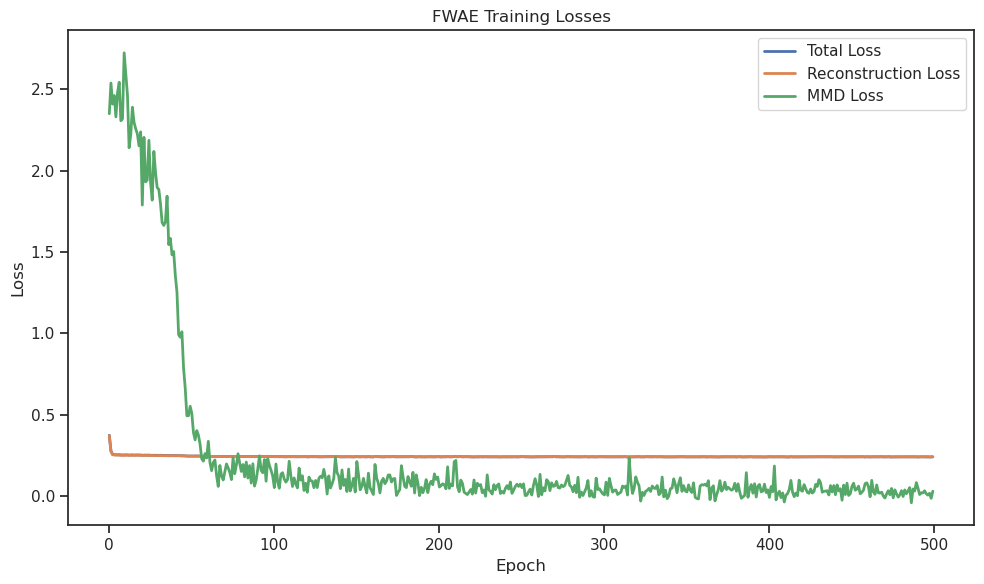

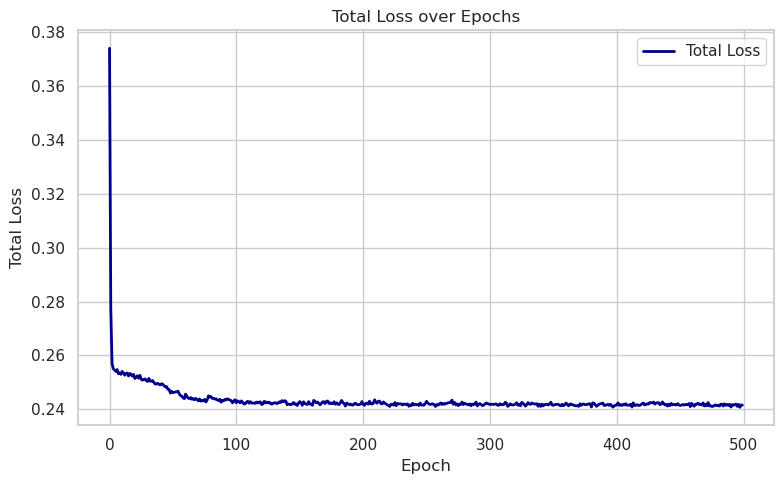

In [ ]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim import AdamW
import torch.nn.functional as F


model = FWAE(raw_x.shape[1]).to(device)
optimizer = AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

def train_FWAE(model, optimizer, dataloader, params):
    model_name = params['model_name']
    num_epoch = params['num_epoch']
    sigma = params['sigma']
    MMD_lambda = params['MMD_lambda']

    folder_dir = os.path.join(os.getcwd(), model_name)
    if not os.path.isdir(folder_dir):
        os.mkdir(folder_dir)

    loss_ = []
    recon_ = []
    MMD_ = []

    for epoch in range(num_epoch):
        total_loss = []
        total_recon = []
        total_MMD = []

        for i, data in enumerate(dataloader):
            x = data[0].to(device)
            y = data[1].to(device)

            model.train()
            recon_x, z_tilde = model(x)

            z = sigma * torch.randn(z_tilde.size()).to(device)

            recon_loss = F.binary_cross_entropy(recon_x, x, reduction='mean')
            

            MMD_loss = imq_kernel(z_tilde, z, h_dim=2).to(device)
            MMD_loss = MMD_loss / x.size(0)
            loss = recon_loss + MMD_lambda * MMD_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss.append(loss.item())
            total_recon.append(recon_loss.item())
            total_MMD.append(MMD_loss.item())

        avg_loss = sum(total_loss) / len(total_loss)
        avg_recon = sum(total_recon) / len(total_recon)
        avg_MMD = sum(total_MMD) / len(total_MMD)

        loss_.append(avg_loss)
        recon_.append(avg_recon)
        MMD_.append(avg_MMD)

        print('[{:03}/{:03}] loss: {:.7f} Recon_loss: {:.7f}, MMD_loss: {:.7f}'.format(
            epoch + 1, num_epoch, avg_loss, avg_recon, avg_MMD))

        if (epoch + 1) % 5 == 0:
            save_model_dir = f"{model_name}_{epoch + 1}.pth"
            torch.save(model.state_dict(), os.path.join(folder_dir, save_model_dir))

    return loss_, recon_, MMD_


loss_, recon_, MMD_ = train_FWAE(model, optimizer, dataloader, params)


df = pd.DataFrame({
    'loss': loss_,
    'recon_loss': recon_,
    'MMD_loss': MMD_
})
df.to_excel('Reconstrction_loss.xlsx', index=False)


plt.figure(figsize=(10, 6))
sns.set_style('ticks')
plt.plot(loss_, label='Total Loss', linewidth=2)
plt.plot(recon_, label='Reconstruction Loss', linewidth=2)
plt.plot(MMD_, label='MMD Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('FWAE Training Losses')
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 5))
sns.set_style('whitegrid')
plt.plot(loss_, color='darkblue', label='Total Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Total Loss over Epochs')
plt.legend()
plt.tight_layout()
plt.show()


**Double check on the reconstructed compositions**
*   one way to find out whether WAE (or any other VAE) has learned the 
repsentation is to compare the reconstructed and original compositions.if you are not happy with the reconstruction. go back to the previous step and change the params. 

In [ ]:
model_name = params['model_name']
folder_dir = os.path.join(os.getcwd(), model_name)


reconstructed_folder = os.path.join(os.getcwd(), 'reconstructeddata')
if not os.path.exists(reconstructed_folder):
    os.makedirs(reconstructed_folder)


model_dir = os.path.join(folder_dir, '{}_{}.pth'.format(params['model_name'], params['num_epoch']))
model = FWAE(raw_x.shape[1]).to(device)  
model.load_state_dict(torch.load(model_dir))
model.eval()


with torch.no_grad():
    test_x = torch.FloatTensor(raw_x).to(device)
    print("test_x shape:", test_x.shape)
    
    
    recon_x, z = model(test_x)
    
    
    recon_x = recon_x.cpu().detach().numpy()


column_name = ['Ba','Ca', 'Sr','Ti','Zr','Sn','Hf']


pd.DataFrame(recon_x.round(3), columns=column_name).iloc[0:155]  

df_x = pd.DataFrame(recon_x.round(5), columns=column_name)  
csv_file_path_x = os.path.join(reconstructed_folder, 'reconstructed_x_data.csv')  
df_x.to_csv(csv_file_path_x, index=False)

print(f"Reconstructed x data saved in folder: {reconstructed_folder}")

test_x shape: torch.Size([154, 7])
Reconstructed x data saved in folder: /mnt/d/博士阶段/机器学习/主动学习CBTS-1xin1.0/reconstructeddata


/tmp/ipykernel_781/43162756.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_dir))


(154, 2)


/tmp/ipykernel_781/1214509040.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_dir))


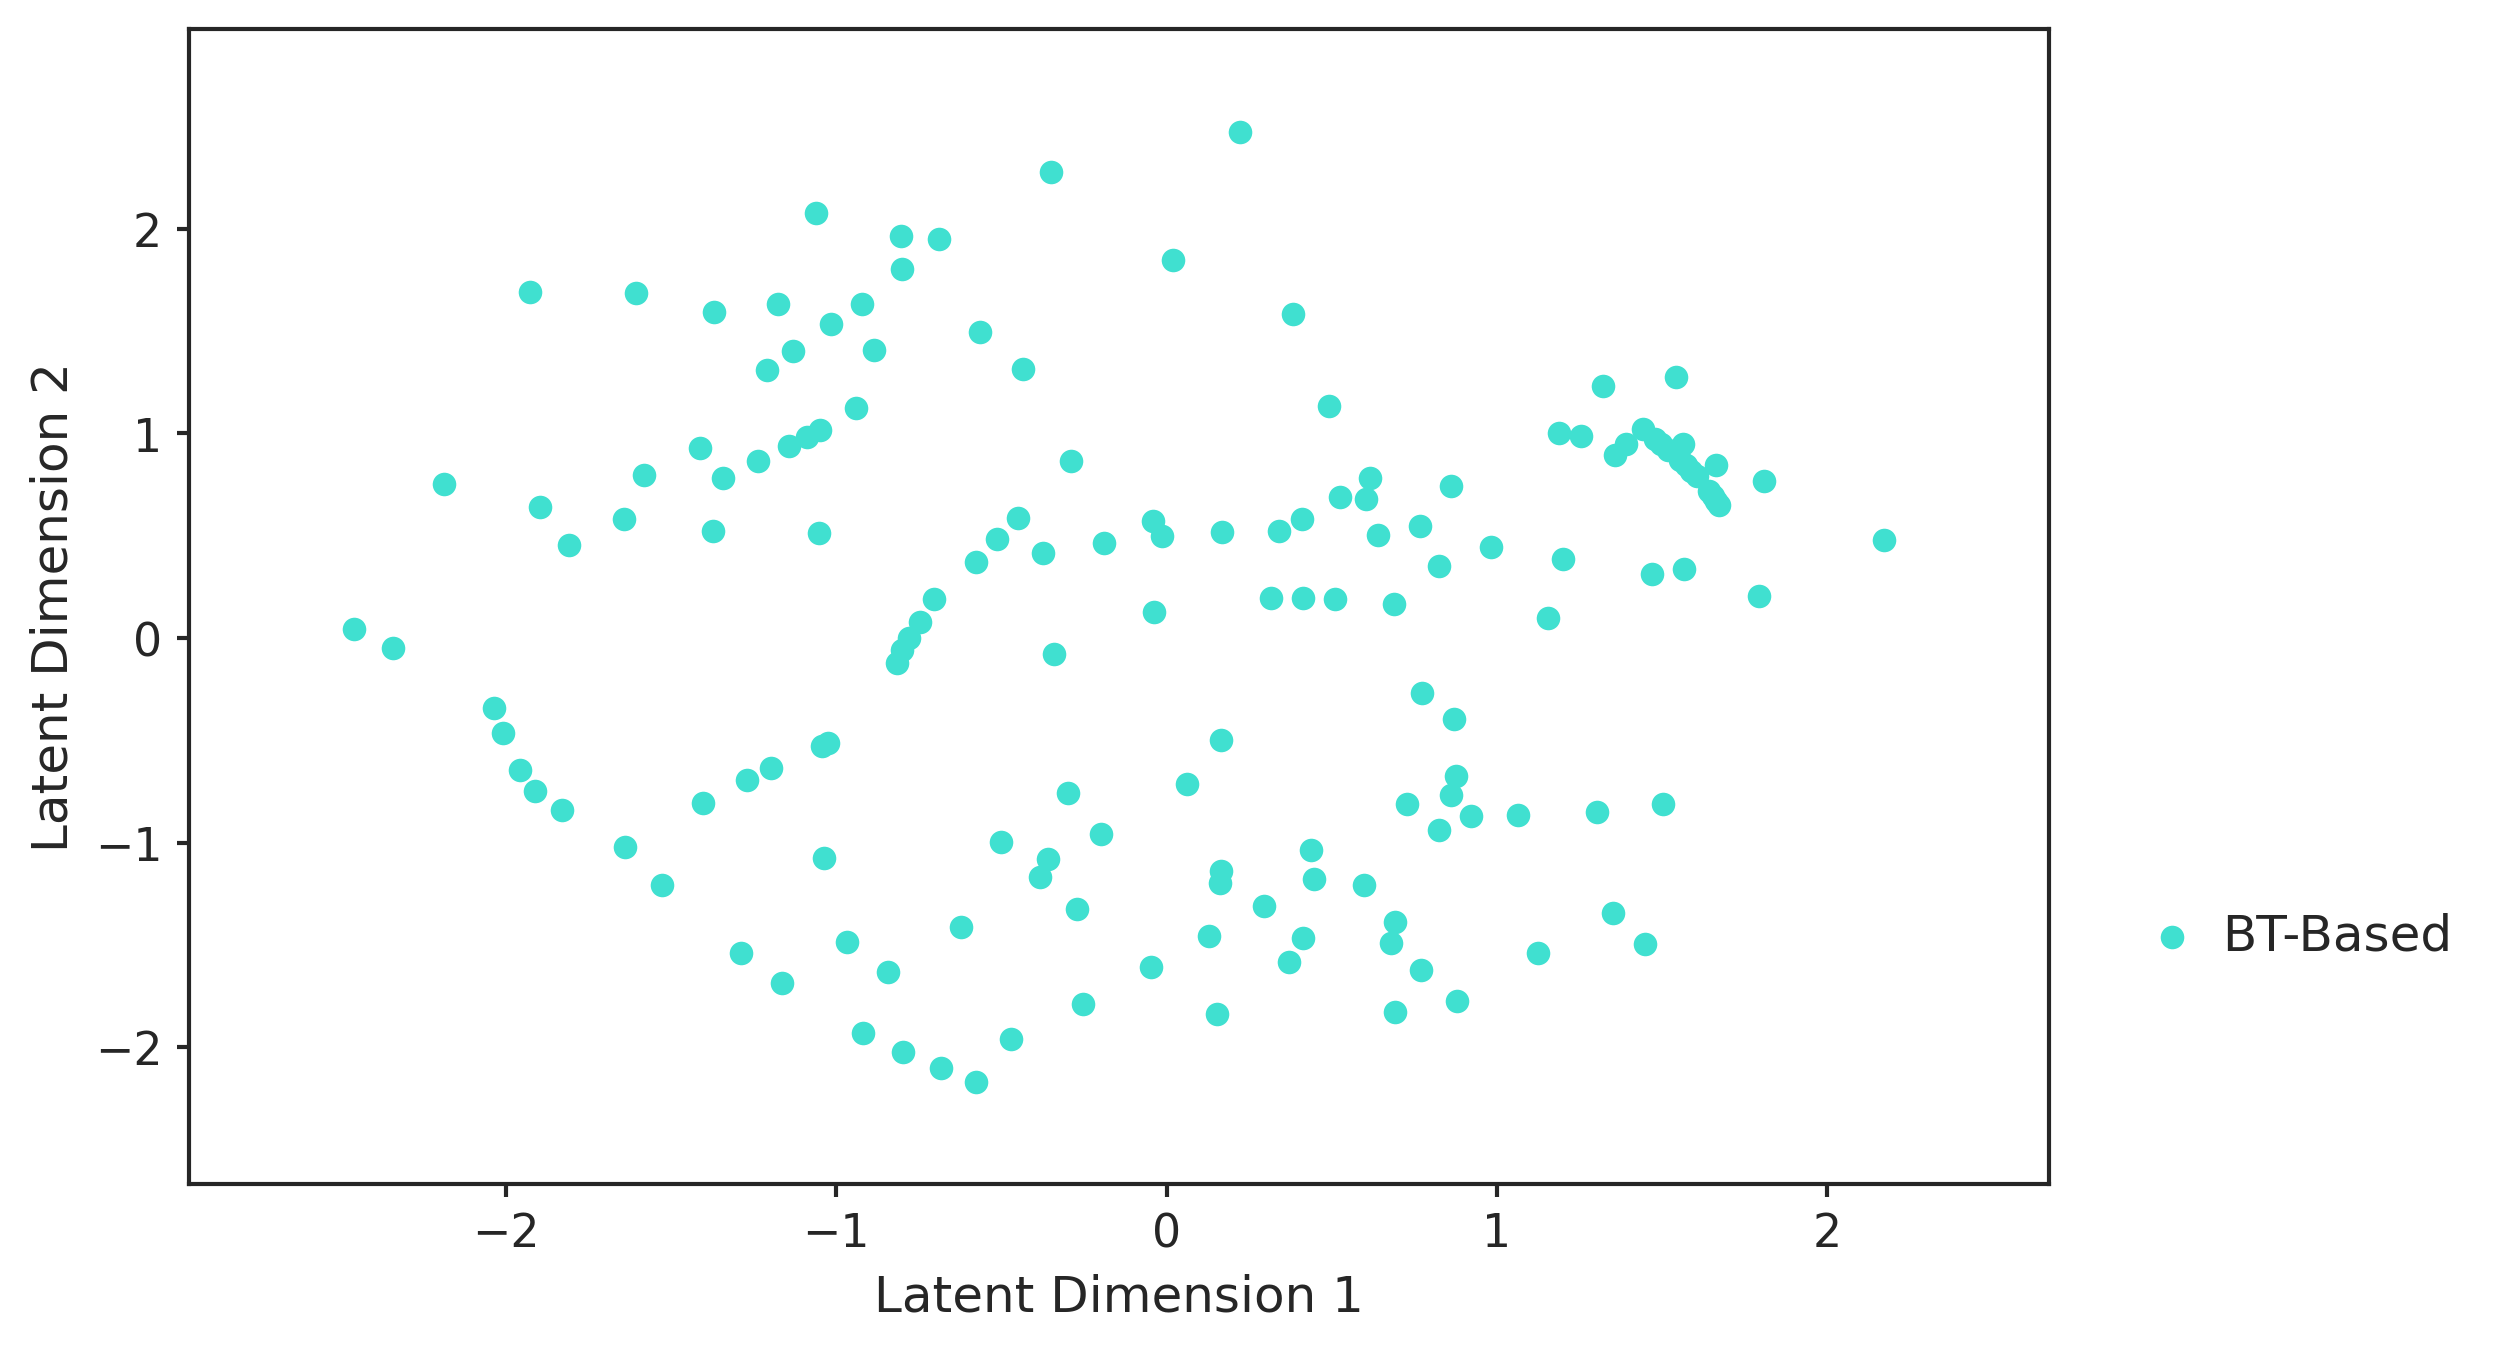

In [ ]:
sns.set_style('ticks')
model = FWAE(raw_x.shape[1]).to(device)
model.load_state_dict(torch.load(model_dir))

dataset = FeatureDataset(raw_x[:], raw_y[:])
latents = get_latents(model, dataset)
print(latents.shape)
# figure setting

fig, axs = plt.subplots(figsize = (8, 5),dpi=300)


axs.set_xlim(np.min(latents[:,0] - 0.5), np.max(latents[:,0] + 0.5))
axs.set_ylim(np.min(latents[:,1] - 0.5), np.max(latents[:,1] + 0.5))



for axis in ['top','bottom','left','right']:
  axs.spines[axis].set_linewidth(1.)

axs.tick_params(axis='both', which='major', top=False, labeltop=False, direction='out', width=1., length=3)
axs.tick_params(axis='both', which='major', right=False, labelright=False, direction='out', width=1, length=3)

scatter1 = axs.scatter(latents[:, 0], latents[:, 1], c='turquoise', alpha=1, s=32, linewidths=0, label='BT-Based')

axs.set_xlabel('Latent Dimension 1', fontsize=12)
axs.set_ylabel('Latent Dimension 2', fontsize=12)

df = pd.DataFrame({
    'latents_0': latents[:, 0],
    'latents_1': latents[:, 1]
})

excel_filename = 'table_latent.xlsx'

df.to_excel(excel_filename, index=False)

handles,labels = axs.get_legend_handles_labels()
handles = handles[::1]
labels = labels[::1]

legend_properties = {'size':12}
axs.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.015,0.275), handletextpad=0, frameon=False, prop=legend_properties)


In [10]:
!pip install numpy matplotlib scikit-learn

AIC/BIC 保存到 n_components/AIC_BIC.xlsx
Log Likelihoods 保存到 n_components/log_likelihoods.xlsx


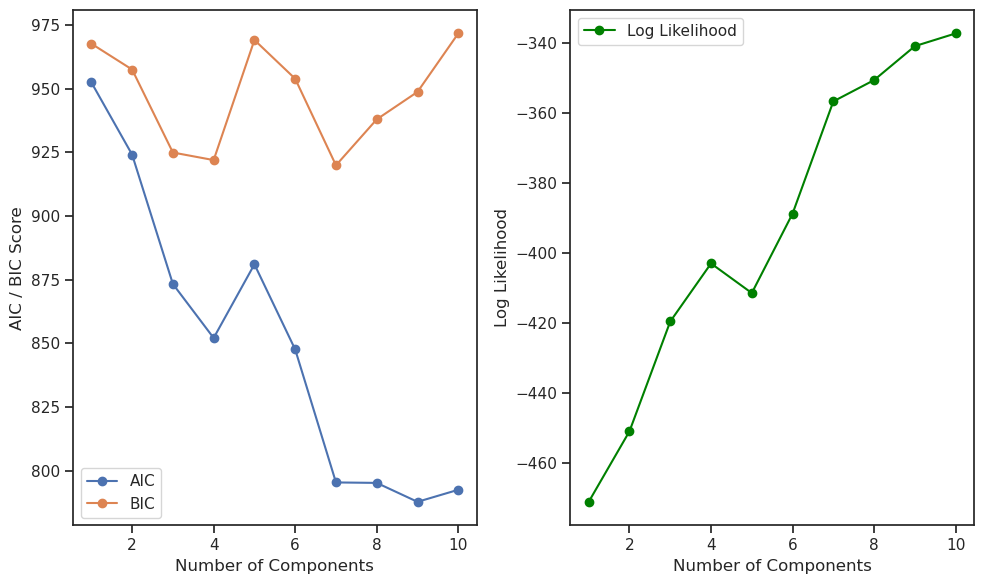

AIC_BIC 图像保存到 n_components/AIC_BIC.png
Log Likelihoods 图像保存到 n_components/log_likelihoods.png


In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import os


folder_name = 'n_components'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

n_components_range = range(1, 11)  
aic_scores = []
bic_scores = []
log_likelihoods = []

for n_components in n_components_range:
    
    gm = GaussianMixture(n_components=n_components, random_state=1, init_params='kmeans').fit(latents)
    
    
    aic_scores.append(gm.aic(latents))
    bic_scores.append(gm.bic(latents))
    
    
    log_likelihood = gm.score(latents) * len(latents)  # log-likelihood per sample
    log_likelihoods.append(log_likelihood)


aic_bic_df = pd.DataFrame({
    'n_components': n_components_range,
    'AIC': aic_scores,
    'BIC': bic_scores
})


log_likelihoods_df = pd.DataFrame({
    'n_components': n_components_range,
    'Log Likelihood': log_likelihoods
})


aic_bic_file_path = os.path.join(folder_name, 'AIC_BIC.xlsx')
aic_bic_df.to_excel(aic_bic_file_path, index=False)


log_likelihoods_file_path = os.path.join(folder_name, 'log_likelihoods.xlsx')
log_likelihoods_df.to_excel(log_likelihoods_file_path, index=False)


print(f"AIC/BIC 保存到 {aic_bic_file_path}")
print(f"Log Likelihoods 保存到 {log_likelihoods_file_path}")


plt.figure(figsize=(10, 6))


plt.subplot(1, 2, 1)
plt.plot(n_components_range, aic_scores, label='AIC', marker='o')
plt.plot(n_components_range, bic_scores, label='BIC', marker='o')
plt.xlabel('Number of Components')
plt.ylabel('AIC / BIC Score')
plt.legend()
aic_bic_plot_path = os.path.join(folder_name, 'AIC_BIC.png')
plt.savefig(aic_bic_plot_path)  


plt.subplot(1, 2, 2)
plt.plot(n_components_range, log_likelihoods, label='Log Likelihood', marker='o', color='green')
plt.xlabel('Number of Components')
plt.ylabel('Log Likelihood')
plt.legend()
log_likelihoods_plot_path = os.path.join(folder_name, 'log_likelihoods.png')
plt.savefig(log_likelihoods_plot_path)  

plt.tight_layout()
plt.show()


print(f"AIC_BIC 图像保存到 {aic_bic_plot_path}")
print(f"Log Likelihoods 图像保存到 {log_likelihoods_plot_path}")

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

Average negative log likelihood: 2.6171759538269903
Data variance: [1.2607192 1.2371218]
Covariance matrix: [[0.32277192 0.06669708]
 [0.06669708 0.09455383]]
Covariance matrix: [[ 0.32128048 -0.40153815]
 [-0.40153815  0.50853485]]
Covariance matrix: [[0.34188644 0.05771755]
 [0.05771755 0.73530386]]
Covariance matrix: [[0.44445931 0.07470566]
 [0.07470566 0.18158551]]
GMM model saved as 'gm_single_class.joblib'


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

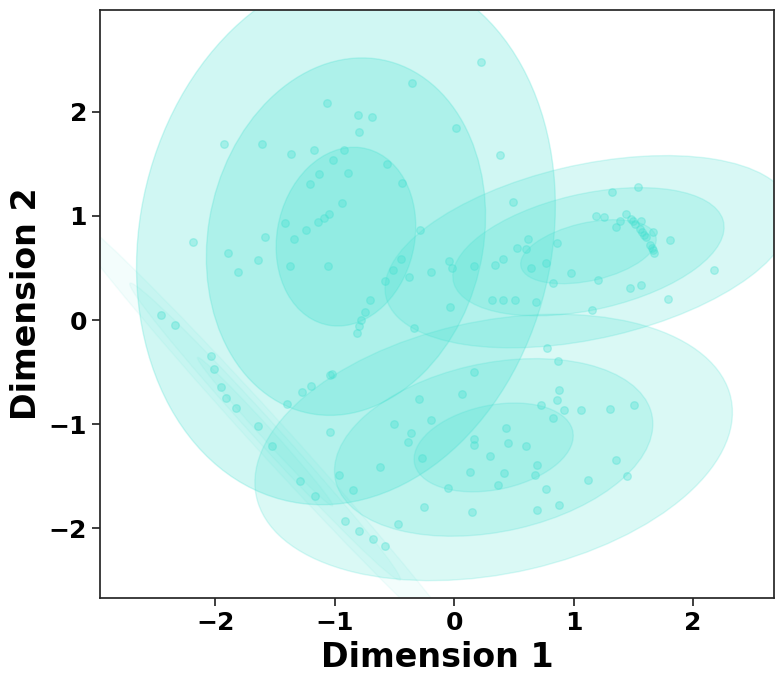

In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from joblib import dump
import matplotlib


matplotlib.rcParams['font.family'] = 'Arial'

def draw_ellipse(position, covariance, ax=None, scale_factor=1, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s) * scale_factor
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance) * scale_factor

    for nsig in range(1, 4):
        ellipse = Ellipse(
            xy=position,
            width=nsig * width,
            height=nsig * height,
            angle=angle,
            **kwargs
        )
        ax.add_patch(ellipse)


color = 'turquoise'

fig, ax = plt.subplots(figsize=(8, 7))

n_components = 4
gm = GaussianMixture(n_components=n_components, random_state=1, init_params='kmeans').fit(latents)
print('Average negative log likelihood:', -1 * gm.score(latents))


ax.scatter(latents[:, 0], latents[:, 1], s=30, marker='o', color=color, alpha=0.3)



ax.set_xlabel('Dimension 1', fontsize=24, fontweight='bold', color='black')
ax.set_ylabel('Dimension 2', fontsize=24, fontweight='bold', color='black')


ax.tick_params(axis='both', labelsize=18, labelcolor='black')
for tick_label in ax.get_xticklabels() + ax.get_yticklabels():
    tick_label.set_fontweight('bold')
    tick_label.set_color('black')


x_min, x_max = np.min(latents[:, 0]) - 0.5, np.max(latents[:, 0]) + 0.5
y_min, y_max = np.min(latents[:, 1]) - 0.5, np.max(latents[:, 1]) + 0.5
max_range = max(x_max - x_min, y_max - y_min)
x_center = (x_max + x_min) / 2
y_center = (y_max + y_min) / 2

ax.set_xlim(x_center - max_range / 2, x_center + max_range / 2)
ax.set_ylim(y_center - max_range / 2, y_center + max_range / 2)


print("Data variance:", np.var(latents, axis=0))
for covar in gm.covariances_:
    print("Covariance matrix:", covar)


for pos, covar, w in zip(gm.means_, gm.covariances_, gm.weights_):
    draw_ellipse(pos, covar, alpha=w * 0.7, color=color, ax=ax)


dump(gm, 'gm_single_class.joblib')
print("GMM model saved as 'gm_single_class.joblib'")

plt.tight_layout()


plt.savefig('Single Class.tiff', dpi=600, format='tiff')
plt.show()


In [ ]:
print(f"Shape of latents: {latents.shape}")


gm = GaussianMixture(n_components=4, random_state=1, init_params='kmeans').fit(latents)


log_likelihoods = gm.score_samples(latents)


for i, log_likelihood in enumerate(log_likelihoods):
    print(f"Data point {i + 1}: Log Likelihood = {log_likelihood}")


df = pd.DataFrame({
    'Log Likelihood': log_likelihoods
})

df.to_csv("log_likelihoods.csv", index_label="Data Point")


Shape of latents: (154, 2)
Data point 1: Log Likelihood = -1.206252670656638
Data point 2: Log Likelihood = -4.082899911412766
Data point 3: Log Likelihood = -1.4777774925595062
Data point 4: Log Likelihood = -3.747093985000926
Data point 5: Log Likelihood = -1.7182302704056347
Data point 6: Log Likelihood = -3.352775511247079
Data point 7: Log Likelihood = -3.330527119842286
Data point 8: Log Likelihood = -1.9972086085922436
Data point 9: Log Likelihood = -1.9056148016683954
Data point 10: Log Likelihood = -2.01631825392363
Data point 11: Log Likelihood = -1.5167419612624402
Data point 12: Log Likelihood = -3.1172118462332477
Data point 13: Log Likelihood = -1.8571402005440714
Data point 14: Log Likelihood = -1.8478604362428184
Data point 15: Log Likelihood = -2.1217835988301648
Data point 16: Log Likelihood = -2.6722851003121453
Data point 17: Log Likelihood = -2.91091272636221
Data point 18: Log Likelihood = -3.2187097078170606
Data point 19: Log Likelihood = -2.5678808929290278
Dat

[0/6] Epoch 1/500 Train Loss: 0.6967, Test Loss: 0.6832, Train Accuracy: 0.4688, Test Accuracy: 0.6538
[0/6] Epoch 2/500 Train Loss: 0.6952, Test Loss: 0.6808, Train Accuracy: 0.4609, Test Accuracy: 0.6538
[0/6] Epoch 3/500 Train Loss: 0.6892, Test Loss: 0.6783, Train Accuracy: 0.5312, Test Accuracy: 0.6538
[0/6] Epoch 4/500 Train Loss: 0.6893, Test Loss: 0.6713, Train Accuracy: 0.5547, Test Accuracy: 0.8077
[0/6] Epoch 5/500 Train Loss: 0.6879, Test Loss: 0.6620, Train Accuracy: 0.5703, Test Accuracy: 0.8077
[0/6] Epoch 6/500 Train Loss: 0.6852, Test Loss: 0.6504, Train Accuracy: 0.5547, Test Accuracy: 0.8846
[0/6] Epoch 7/500 Train Loss: 0.6776, Test Loss: 0.6388, Train Accuracy: 0.5469, Test Accuracy: 0.8846
[0/6] Epoch 8/500 Train Loss: 0.6765, Test Loss: 0.6210, Train Accuracy: 0.5703, Test Accuracy: 0.8462
[0/6] Epoch 9/500 Train Loss: 0.6680, Test Loss: 0.5958, Train Accuracy: 0.5703, Test Accuracy: 0.8462
[0/6] Epoch 10/500 Train Loss: 0.6639, Test Loss: 0.5679, Train Accuracy:

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

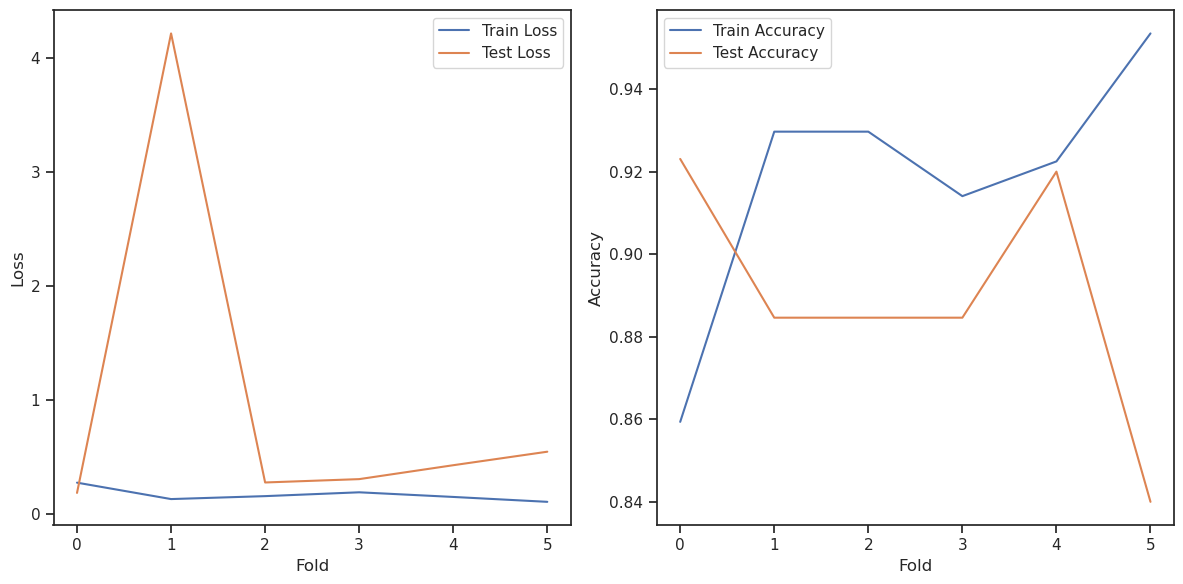

In [ ]:
import random
import time
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import KFold


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_random_seed(1)


class AttributeDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        return torch.Tensor(self.x[idx]), torch.Tensor(self.y[idx])


class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 256),  
            nn.ReLU(),         
            nn.Dropout(0.48),
            nn.Linear(256, 128),  
            nn.ReLU(),         
            nn.Dropout(0.48),
            nn.Linear(128, 32),  
            nn.ReLU(),         
            nn.Dropout(0.48),
            nn.Linear(32, 16),  
            nn.ReLU(),         
            nn.Dropout(0.48),
            nn.Linear(16, 1),   
            nn.Sigmoid()        
        )
    def forward(self, x):
        return self.fc(x)

params = {
    'cls_bs': 15,  
    'cls_lr': 8e-4,  
    'cls_epoch': 500,  
    'num_fold': 6,  
    'latents': latents,  
}


threshold = 300
label_y = np.where(raw_y < threshold, 1, 0)  
params['label_y'] = label_y  


folder_name = 'classification_results'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

cls = Classifier().to(device)
opt = Adam(cls.parameters(), lr=params['cls_lr'], weight_decay=0.00001)


from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(opt, step_size=20, gamma=0.5)  


def training_Cls(model, optimizer, scheduler, params):
    results = {'train_loss': [], 'test_loss': [], 'train_accuracy': [], 'test_accuracy': []}
    
    label_y = params['label_y']
    latents = params['latents']
    cls_epoch = params['cls_epoch']
    kf = KFold(n_splits=params['num_fold'], shuffle=True, random_state=1)
    
    fold = 0
    for train, test in kf.split(latents, label_y):
        x_train, x_test = latents[train], latents[test]
        y_train, y_test = label_y[train], label_y[test]

        
        cls_dataset = AttributeDataset(x_train, y_train)
        cls_dataloader = DataLoader(cls_dataset, batch_size=params['cls_bs'], shuffle=True)
        cls_testDataset = AttributeDataset(x_test, y_test)
        cls_testDataloader = DataLoader(cls_testDataset, batch_size=cls_testDataset.__len__(), shuffle=False)

        for epoch in range(cls_epoch):
            model.train()
            total_train_loss, correct_train_preds = 0, 0
            for i, data in enumerate(cls_dataloader):
                x = data[0].to(device)
                y = data[1].to(device).view(-1, 1)  
                y_pred = model(x)
                loss = F.binary_cross_entropy(y_pred, y.float())   

                pred_labels = (y_pred > 0.5).float()  
                correct_train_preds += (pred_labels == y).sum().item()
                total_train_loss += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            train_accuracy = correct_train_preds / len(x_train)

            
            model.eval()
            total_test_loss, correct_test_preds = 0, 0
            with torch.no_grad():
                for test in cls_testDataloader:
                    x = test[0].to(device)
                    y = test[1].to(device).view(-1, 1)  
                    y_pred = model(x)
                    test_loss = F.binary_cross_entropy(y_pred, y.float())

                    pred_labels = (y_pred > 0.5).float()
                    correct_test_preds += (pred_labels == y).sum().item()
                    total_test_loss += test_loss.item()

            test_accuracy = correct_test_preds / len(x_test)

            print(f'[{fold}/{params["num_fold"]}] Epoch {epoch+1}/{cls_epoch} '
                  f'Train Loss: {total_train_loss/len(cls_dataloader):.4f}, '
                  f'Test Loss: {total_test_loss/len(cls_testDataloader):.4f}, '
                  f'Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Accuracy: {test_accuracy:.4f}')
        
        results['train_loss'].append(total_train_loss / len(cls_dataloader))
        results['test_loss'].append(total_test_loss / len(cls_testDataloader))
        results['train_accuracy'].append(train_accuracy)
        results['test_accuracy'].append(test_accuracy)

        fold += 1

        
        scheduler.step()

    return results


results = training_Cls(cls, opt, scheduler, params)

torch.save(cls.state_dict(), 'classifier_model.pth')
print("模型已保存为 'classifier_model.pth'")


df_loss = pd.DataFrame({'Train Loss': results['train_loss'], 'Test Loss': results['test_loss']})
df_accuracy = pd.DataFrame({'Train Accuracy': results['train_accuracy'], 'Test Accuracy': results['test_accuracy']})

df_loss.to_excel(os.path.join(folder_name, 'Loss.xlsx'), index=False)
df_accuracy.to_excel(os.path.join(folder_name, 'Accuracy.xlsx'), index=False)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(results['train_loss'], label='Train Loss')
plt.plot(results['test_loss'], label='Test Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results['train_accuracy'], label='Train Accuracy')
plt.plot(results['test_accuracy'], label='Test Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import torch
import joblib  
import torch.nn.functional as F

np.random.seed(1)
def MCMC(gms, cls, n_samples, sigma=0.1):
    sample_z = []
    all_z_trace = []  

    
    z = gms.sample(1)[0]  

    for i in range(n_samples):
        uniform_rand = np.random.uniform(size=1)
        
        z_next = np.random.multivariate_normal(z.squeeze(), sigma * np.eye(2)).reshape(1, -1)

        z_combined = np.concatenate((z, z_next), axis=0)  
        
        outputs = cls(torch.Tensor(z_combined).to(device)).detach().cpu().numpy().squeeze()
        z_output, z_next_output = outputs[0], outputs[1] 

       
        z_prob = gms.score(z) + np.log(max(z_output, 1e-8))  
        z_next_prob = gms.score(z_next) + np.log(max(z_next_output, 1e-8))

        
        acceptance = min(0, (z_next_prob - z_prob))

        
        if i == 0:
            sample_z.append(z.squeeze())
            
        
        all_z_trace.append(z_next.squeeze())

        if np.log(uniform_rand) < acceptance:
            sample_z.append(z_next.squeeze())
            z = z_next  

    return np.stack(sample_z), np.stack(all_z_trace)


cls = Classifier().to(device)  
cls.load_state_dict(torch.load('classifier_model.pth'))  
cls.eval()  

gms = joblib.load('gm_single_class.joblib')  


n_samples = 30000
sample_z_array, all_z_trace_array = MCMC(gms=gms, cls=cls, n_samples=30000, sigma=0.5)

sample_z_tensor = torch.tensor(sample_z_array, dtype=torch.float32).to(device)
all_z_trace_tensor = torch.tensor(all_z_trace_array, dtype=torch.float32).to(device)


latent_df = pd.DataFrame(sample_z_array, columns=['latent_0', 'latent_1'])
latent_df.to_csv('latent_samples_before_decode.csv', index=False)


trace_df = pd.DataFrame(all_z_trace_array, columns=['latent_0', 'latent_1'])
trace_df.to_csv('latent_trace_all_points.csv', index=False)


WAE_comps = model._decode(sample_z_tensor.float().to(device)).detach().cpu().numpy()


WAE_comps = pd.DataFrame(WAE_comps)
WAE_comps.columns = column_name  
WAE_comps.to_csv('comps_samples.csv', index=False, encoding='utf-8')


print(WAE_comps.shape[0])

tolerance = 1e-3


filtered_latents = []
filtered_decoded = []


for z_vec, decoded_vec in zip(sample_z_tensor.cpu().numpy(), WAE_comps.values):
    decoded_vec = np.array(decoded_vec)  
    sum_first3 = decoded_vec[:3].sum()
    sum_last4 = decoded_vec[-4:].sum()

    if abs(sum_first3 - 0.5) <= tolerance and abs(sum_last4 - 0.5) <= tolerance:
        filtered_latents.append(z_vec)
        filtered_decoded.append(decoded_vec)


filtered_latents_df = pd.DataFrame(filtered_latents, columns=['latent_0', 'latent_1'])
filtered_decoded_df = pd.DataFrame(filtered_decoded, columns=column_name)


filtered_latents_df.to_csv('filtered_latents.csv', index=False, encoding='utf-8')
filtered_decoded_df.to_csv('filtered_decoded_comps.csv', index=False, encoding='utf-8')


print("筛选后样本数量：", len(filtered_latents))

/tmp/ipykernel_781/4181915130.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cls.load_state_dict(torch.load('classifier_model.pth'))  # 加载之前训练好的分类器模型


11884
筛选后样本数量： 3871
